Trabajo Práctico 4: Aprendizaje No-Supervisado

In [ ]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import src.preprocessing as pre
import src.metrics as metrics
import src.models as models
import src.pytorchmodels as torchmodels

from typing import Dict, Iterable, Tuple, Optional

np.set_printoptions(suppress=True, linewidth=120)
plt.rcParams["figure.dpi"] = 120
RNG_SEED = 0
rng = np.random.default_rng(RNG_SEED)

# ====== Celda 3: Cargar datos y split ======
X, y = pre.load_faces_csv("data/caras.csv", label_col="person_id")
print("X:", X.shape, "y:", y.shape, "#clases:", np.unique(y).size)

(Xtr, ytr), (Xte, yte) = pre.stratified_split(X, y, test_size=0.2, random_state=RNG_SEED)
print("train:", Xtr.shape, "classes:", np.unique(ytr).size, "| test:", Xte.shape, "classes:", np.unique(yte).size)


X: (400, 4096) y: (400,) #clases: 40
train: (320, 4096) classes: 40 | test: (80, 4096) classes: 40


1. Inspección de los datos

1.1 Primera Observacion de los Datos

Comienzo por observar 15 imagenes seleccionadas de manera aleatoria.

In [ ]:
idxs = np.random.choice(len(X), size=15, replace=False)


pre.plot_images(X, idxs, img_shape=(64, 64), suptitle="Mosaico aleatorio (15)");

AttributeError: module 'src.preprocessing' has no attribute 'plot_images'

1.2 Analisis Exploratorio de la Distribución de Clases

Grafico muestras agrupadas por clase, para 5 clases.

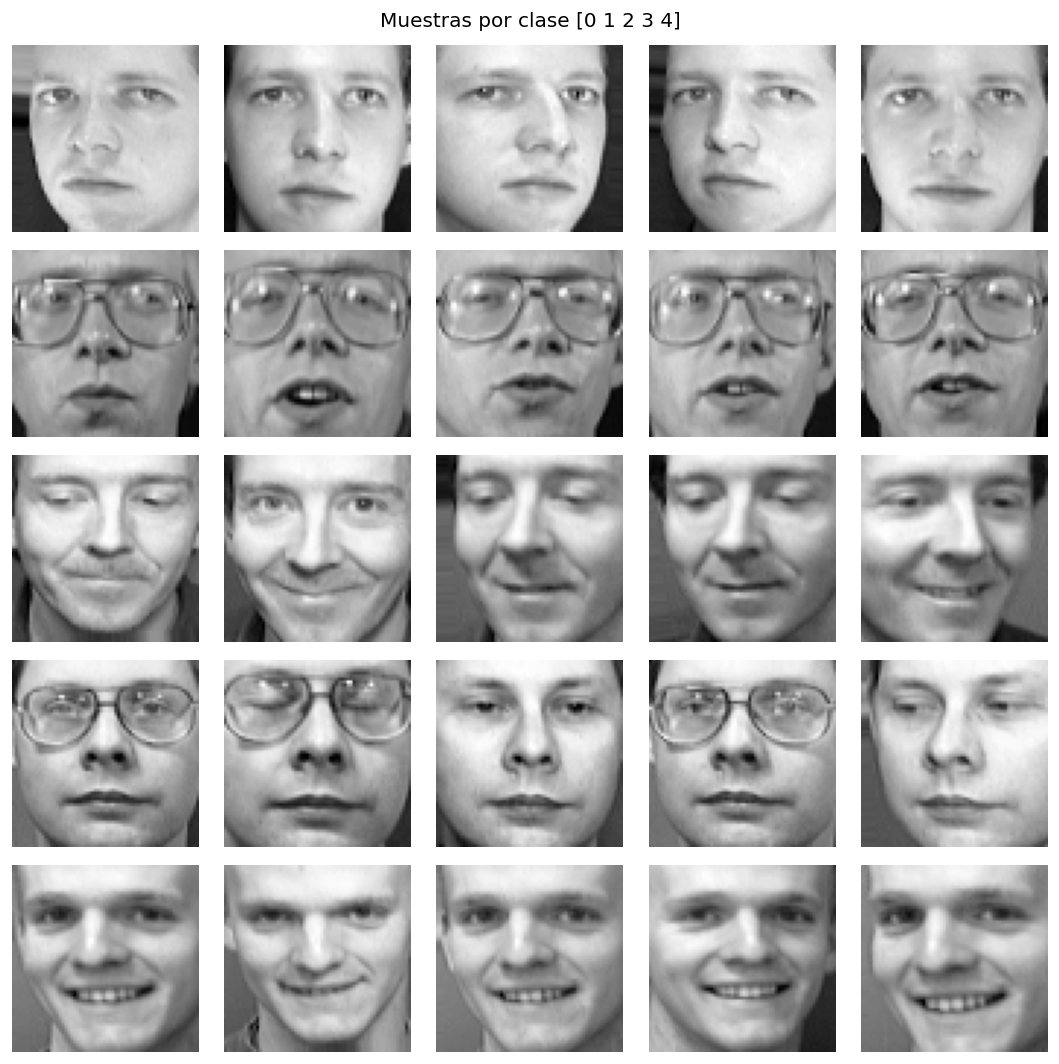

In [36]:
# distribución de clases
vals, counts = np.unique(y, return_counts=True)

# muestras por 5 clases (elige automáticamente las 5 más frecuentes)
top5 = vals[np.argsort(-counts)[:5]]
pre.plot_by_class(X, y, top5, per_class=5);

Grafico la distribucion de las clases

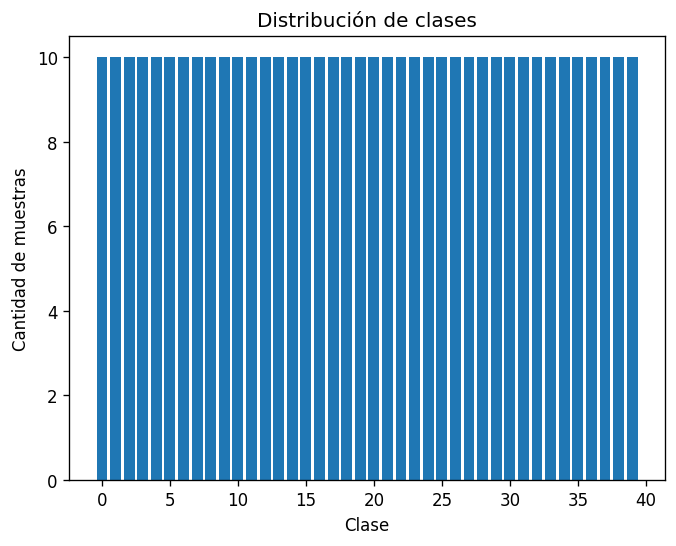

In [37]:
# grafico la distribucion de las clases
plt.bar(vals, counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de muestras")
plt.title("Distribución de clases")
plt.show()

Las clases estan perfectamente balanceadas con igual cantidad de muestras por clase. Por el momento no aplico ningun cambio en el dataset.

1.3 Split de los Datos

Separo los datos en Train (80%) y Test (20%)

In [38]:
(Xtr, ytr), (Xte, yte) = pre.stratified_split(X, y, test_size=0.2, random_state=0)
print("train:", Xtr.shape, np.unique(ytr).size, "| test:", Xte.shape, np.unique(yte).size)

train: (320, 4096) 40 | test: (80, 4096) 40


2. Reducción de dimensionalidad

2.1 Aplicación de PCA

Estandarización de los datos

In [39]:
std = pre.standardize_fit(Xtr)
Xtr_std = pre.standardize_transform(Xtr, std)
Xte_std = pre.standardize_transform(Xte, std)

Aplico PCA a los datos estandarizados

In [40]:
pca = pre.pca_fit(Xtr_std)

2.2 Analisis del PCA

Grafico de la varianza explicada acumulada en función del numero de componentes

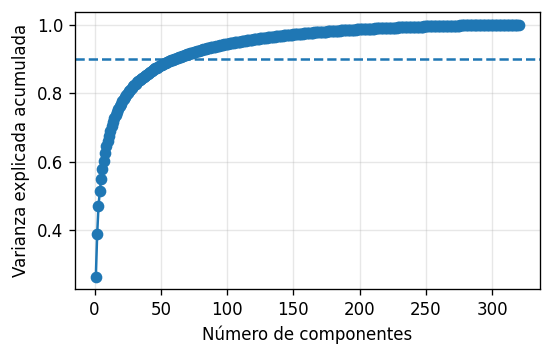

In [41]:

fig = pre.explained_variance_plot(pca)


Me quedo con el número de componentes que me aseguren explicar el 90 % de la
varianza de los dato denotada por la linea punteada del grafico anterior

In [42]:
k90 = int(np.searchsorted(pca["cum_explained_ratio"], 0.90) + 1)
k_pca = max(2, k90)  # para clustering, al menos 2 dim
Ztr_pca = pre.pca_transform(Xtr_std, pca, k=k_pca)
Zte_pca = pre.pca_transform(Xte_std, pca, k=k_pca)

Para comparar los datos originales con la reduccion de dimensionalidad hecha con PCA grafico 10 imagenes

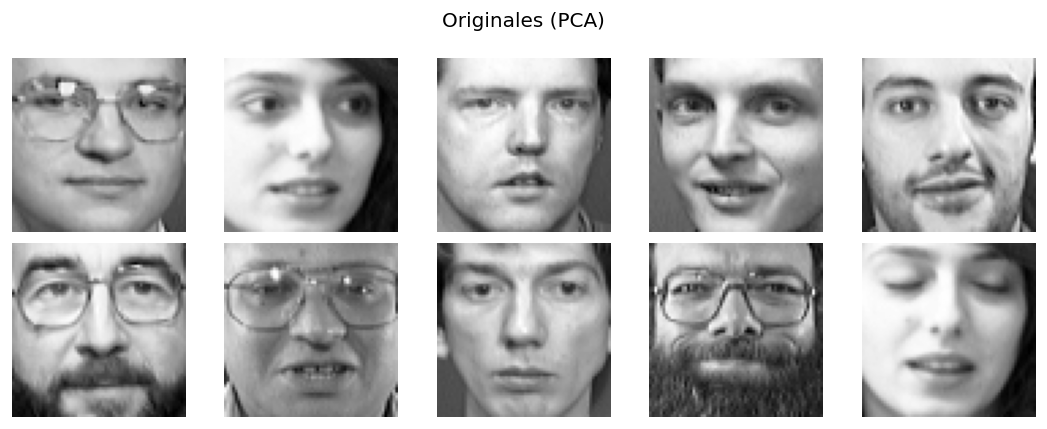

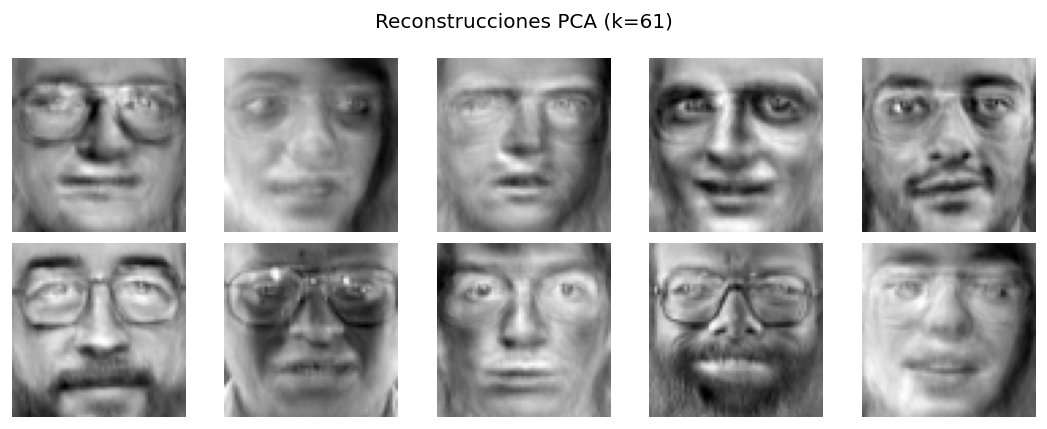

In [43]:
# Reconstrucciones con k90 y comparación visual (2.b)
Xtr_rec = pre.pca_inverse_transform(Ztr_pca, pca, k=k90, X_mean=Xtr.mean(axis=0, keepdims=True))
idxs = np.random.choice(len(Xtr), size=10, replace=False)
pre.plot_images(Xtr, idxs, suptitle="Originales (PCA)");
pre.plot_images(Xtr_rec, idxs, suptitle=f"Reconstrucciones PCA (k={k90})");

2.3 Aplicacion de AutoEncoder Deterministico

Para la implementacion del Autoencoder utilizo PyTorch

In [ ]:
import torch, torch.nn as nn, torch.optim as optim

Defino el modelo y convierto los datos a tensores

In [ ]:
D = Xtr_std.shape[1]
k = k90

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = torchmodels.Autoencoder(D, k).to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

# Convierto los datos a tensores y muevo a device
Xtr_t = torch.from_numpy(Xtr_std).float().to(device)
Xte_t = torch.from_numpy(Xte_std).float().to(device)


Entrenamiento y evaluacion del autoencoder

In [ ]:
for epoch in range(50):
    ae.train()
    opt.zero_grad()
    xr, _ = ae(Xtr_t)
    loss = loss_fn(xr, Xtr_t)
    loss.backward(); opt.step()

ae.eval()
with torch.no_grad():
    xr_val, z_val = ae(Xte_t)
Xte_rec = xr_val.cpu().numpy()

2.4 Comparacion entre Las imagenes reconstruidas con PCA y AE

Grafico el las imagenes originales, las de PCA y las del AE

KeyError: 'sigma'

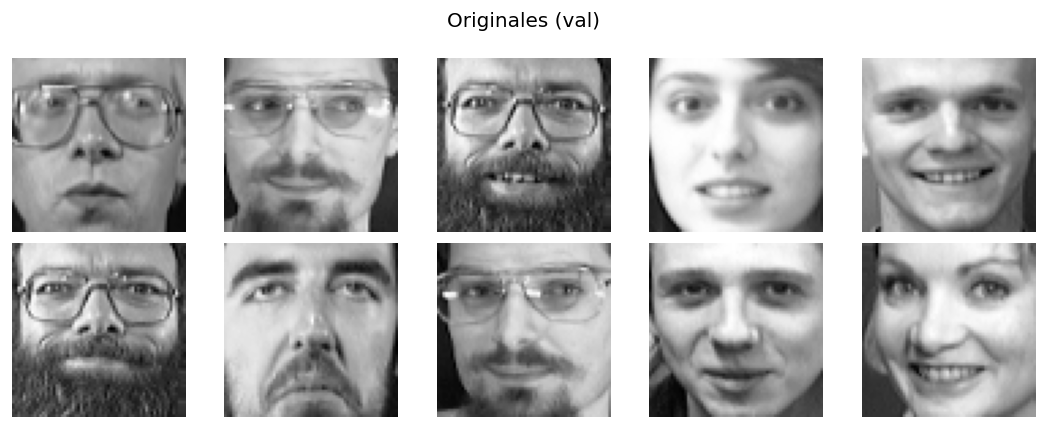

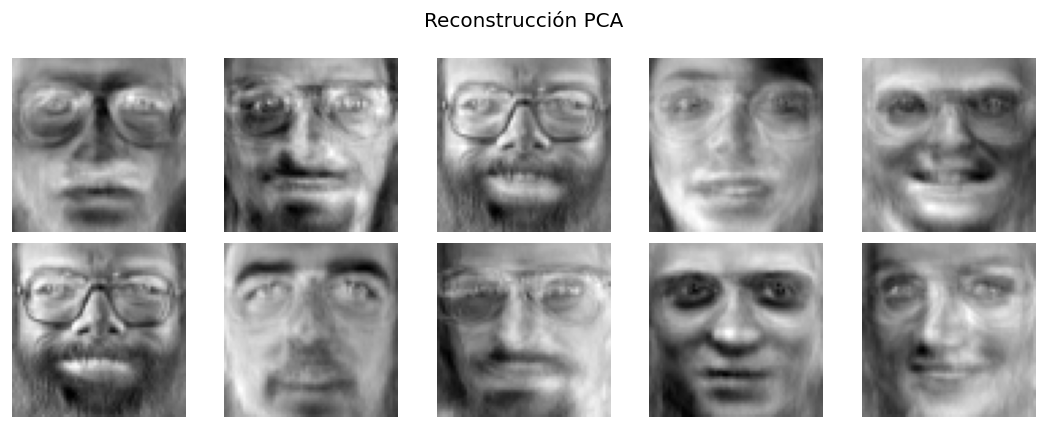

In [ ]:

idxs = np.random.choice(len(Xte), size=10, replace=False)
pre.plot_images(Xte, idxs, suptitle="Originales (val)");
pre.plot_images(pre.pca_inverse_transform(pre.pca_transform(Xte_std, pca, k), pca, k, X_mean=Xte.mean(0, keepdims=True)), idxs, suptitle="Reconstrucción PCA");
pre.plot_images((Xte_rec * std["sigma"] + std["mu"]), idxs, suptitle="Reconstrucción AE");


2.5 Aplicación de las transformaciones aprendida a train y test

In [ ]:
# Z de PCA ya están (Ztr_pca, Zte_pca)
Ztr_ae = z_val.cpu().numpy() if 'z_val' in locals() else None  # si querés, recalcular sobre train también
with torch.no_grad():
    z_tr = ae.enc(torch.from_numpy(Xtr_std).float().to(device)).cpu().numpy()
    z_te = ae.enc(torch.from_numpy(Xte_std).float().to(device)).cpu().numpy()


3. Clustering

3.1 Implementación de K-Means

Pruebo valores de K dentro del rango de [5, 20] 

In [ ]:
Ks = range(5, 21)
results = []
for rep_space, Ztr in [("PCA", Ztr_pca), ("AE", z_tr)]:
    inertias = []
    sils = []
    for K in Ks:
        km = models.KMeans(n_clusters=K, n_init=5, max_iter=300, random_state=0).fit(Ztr)
        inertias.append(km.inertia_)
        sils.append(metrics.silhouette_score(Ztr, km.labels_))
    results.append((rep_space, np.array(inertias), np.array(sils)))

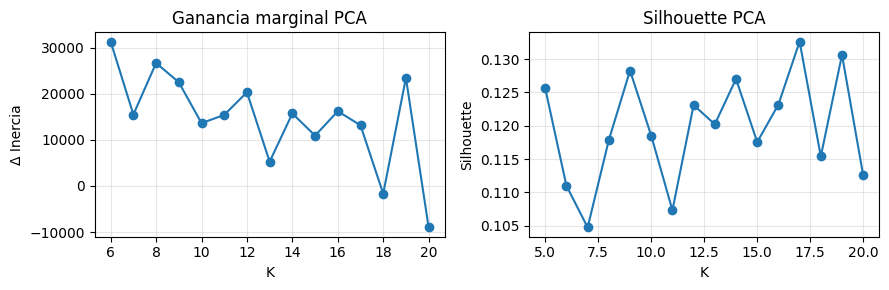

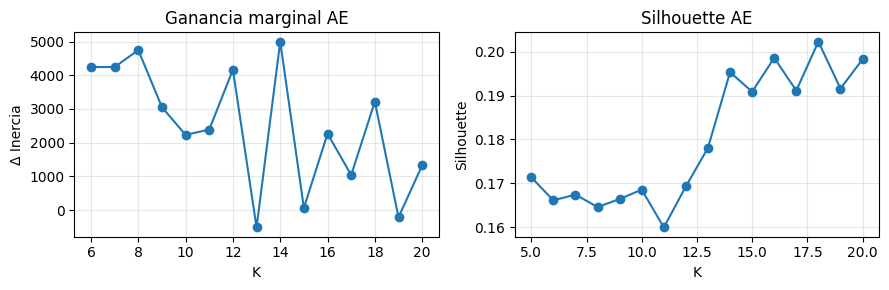

In [ ]:
# graficar elbow (ganancia marginal) y silhouette (3.c)
import matplotlib.pyplot as plt
for rep_space, inertias, sils in results:
    gains = metrics.elbow_gains(inertias)
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(list(Ks), gains, marker='o'); ax[0].set_title(f'Ganancia marginal {rep_space}')
    ax[0].set_xlabel('K'); ax[0].set_ylabel('Δ Inercia'); ax[0].grid(True, alpha=0.3)
    ax[1].plot(list(Ks), sils, marker='o'); ax[1].set_title(f'Silhouette {rep_space}')
    ax[1].set_xlabel('K'); ax[1].set_ylabel('Silhouette'); ax[1].grid(True, alpha=0.3)
    plt.tight_layout()

3.2 Implementación de GMM

Pruebo valores de K dentro del rango de [5, 20] 

Sugerencia por BIC: K = 5
Sugerencia por Silhouette: 5
K válidos para silhouette: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Sugerencia por BIC: K = 5
Sugerencia por Silhouette: 5
K válidos para silhouette: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


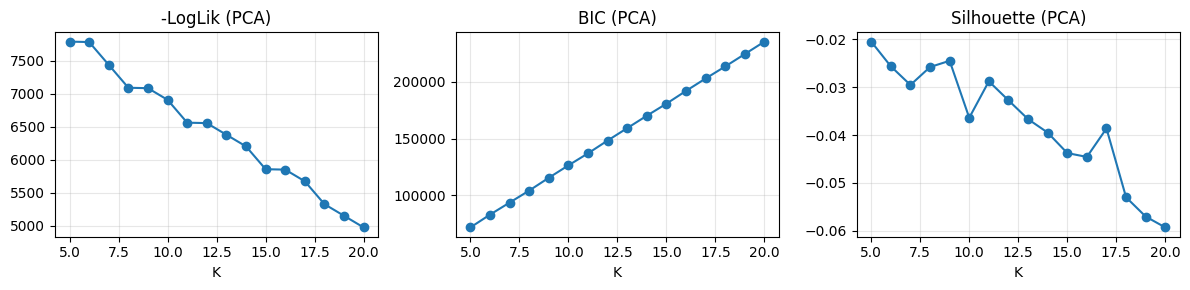

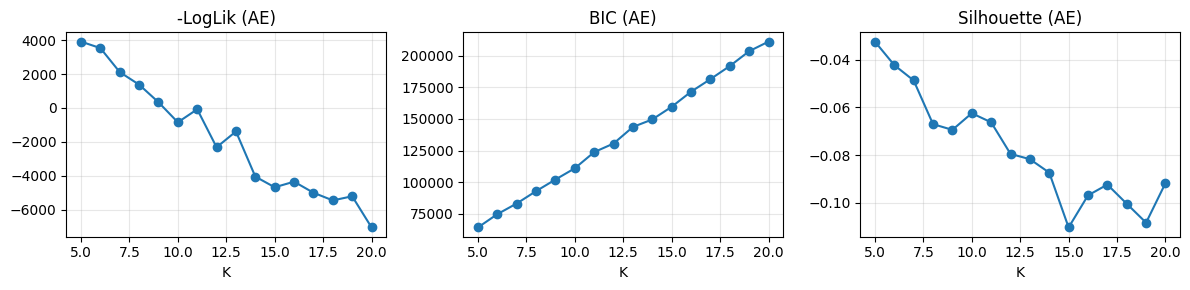

In [ ]:
Ks = range(5, 21)

Ztr_pca_gmm = pre.z_standardize(Ztr_pca)

def plot_gmm_model_selection(res, title_suffix=""):
    Ks = res["Ks"]
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].plot(Ks, -res["loglik"], marker="o"); ax[0].set_title(f"-LogLik {title_suffix}")
    ax[0].set_xlabel("K"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(Ks, res["BIC"], marker="o"); ax[1].set_title(f"BIC {title_suffix}")
    ax[1].set_xlabel("K"); ax[1].grid(True, alpha=0.3)

    sil = res["silhouette"]
    mask = ~np.isnan(sil)
    ax[2].plot(Ks[mask], sil[mask], marker="o")
    ax[2].set_title(f"Silhouette {title_suffix}")
    ax[2].set_xlabel("K"); ax[2].grid(True, alpha=0.3)

    plt.tight_layout()
    k_bic = Ks[np.argmin(res["BIC"])]
    k_sil = Ks[mask][np.argmax(sil[mask])] if mask.any() else None
    print(f"Sugerencia por BIC: K = {k_bic}")
    print(f"Sugerencia por Silhouette: {k_sil if k_sil is not None else '— (ningún K válido)'}")
    print(f"K válidos para silhouette: {Ks[mask].tolist()}")
    return k_bic, (k_sil if k_sil is not None else np.nan)

# En PCA
res_pca = models.gmm_sweep_over_K(
    Ztr_pca_gmm, range(5,21),
    n_init=10,              # más reinicios
    random_state=0
)
k_bic_pca, k_sil_pca = plot_gmm_model_selection(res_pca, title_suffix="(PCA)")

# En AE
res_ae = models.gmm_sweep_over_K(z_tr, Ks, n_init=5, random_state=0)
k_bic_ae, k_sil_ae = plot_gmm_model_selection(res_ae, title_suffix="(AE)")


Elijo el mejor K

In [2]:

# ---------- utilidades ----------
def z_standardize_fit(Z):
    mu = Z.mean(axis=0, keepdims=True)
    sd = Z.std(axis=0, ddof=1, keepdims=True)
    sd[sd == 0] = 1.0
    return {"mu": mu, "sd": sd}

def z_standardize_transform(Z, st):
    return (Z - st["mu"]) / st["sd"]

def fit_final_gmm(Ztr, K, cov_type="diag", reg_covar=1e-2, n_init=10, random_state=0):
    """
    Varios reinicios, k-means init en el primero, mejor por loglik.
    Devuelve (gmm_mejor, labels, silhouette, tabla_tamanos).
    """
    rng = np.random.default_rng(random_state)
    best = {"model": None, "loglik": -np.inf, "labels": None}
    # kmeans init para la primera corrida
    km = models.KMeans(n_clusters=K, n_init=5, random_state=random_state).fit(Ztr)
    init_means_list = [km.cluster_centers_]
    for _ in range(n_init-1):
        idx = rng.choice(Ztr.shape[0], size=K, replace=False)
        init_means_list.append(Ztr[idx].copy())

    for init_means in init_means_list:
        gmm = models.GMM(n_components=K, random_state=random_state, reg_covar=reg_covar,
                  init_means=init_means, cov_type=cov_type).fit(Ztr)
        ll = gmm.loglik_
        labs = gmm.predict(Ztr)
        if ll > best["loglik"]:
            best.update({"model": gmm, "loglik": ll, "labels": labs})

    labs = best["labels"]
    uniq, counts = np.unique(labs, return_counts=True)
    # silhouette válido solo si hay ≥2 clusters y ninguno singleton
    sil = (np.nan if (len(uniq) < 2 or (counts < 2).any())
           else metrics.silhouette_score(Ztr, labs))
    sizes = pd.Series(counts, index=uniq, name="size").sort_values(ascending=False)
    return best["model"], labs, sil, sizes

def choose_final_k(k_bic, k_sil):
    """Si silhouette devolvió NaN o dio valores muy dispares, quedate con BIC por defecto."""
    if k_sil is None or (isinstance(k_sil, float) and np.isnan(k_sil)):
        return int(k_bic)
    return int(k_bic)  # podés cambiar a alguna heurística híbrida si querés


In [3]:
# Elegimos K finales (usando lo que ya encontraste)
K_PCA = choose_final_k(k_bic_pca, k_sil_pca)
K_AE  = choose_final_k(k_bic_ae,  k_sil_ae)

# Estandarizamos latentes ANTES de GMM
st_pca = z_standardize_fit(Ztr_pca)
Ztr_pca_gmm = z_standardize_transform(Ztr_pca, st_pca)

st_ae  = z_standardize_fit(z_tr)
Ztr_ae_gmm  = z_standardize_transform(z_tr, st_ae)

# Fit finales (robustos)
gmm_pca, labels_pca, sil_pca_final, sizes_pca = fit_final_gmm(
    Ztr_pca_gmm, K_PCA, cov_type="diag", reg_covar=1e-2, n_init=10, random_state=0
)
gmm_ae, labels_ae, sil_ae_final, sizes_ae = fit_final_gmm(
    Ztr_ae_gmm,  K_AE,  cov_type="diag", reg_covar=1e-2, n_init=10, random_state=0
)

print("=== PCA ===")
print("K final:", K_PCA, "| silhouette:", sil_pca_final)
print("Tamaños por cluster:\n", sizes_pca.to_string())
print("\n=== AE ===")
print("K final:", K_AE,  "| silhouette:", sil_ae_final)
print("Tamaños por cluster:\n", sizes_ae.to_string())


NameError: name 'k_bic_pca' is not defined

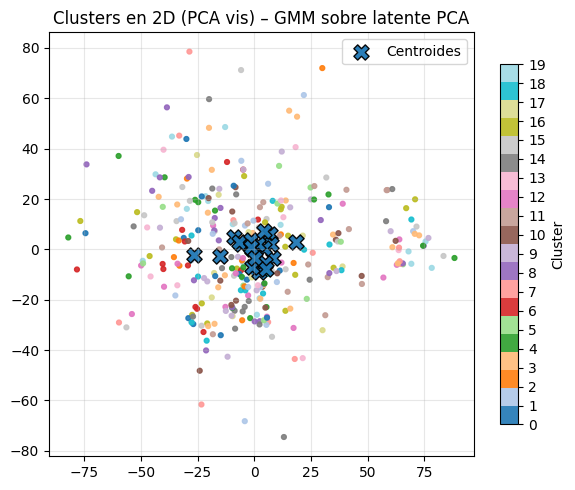

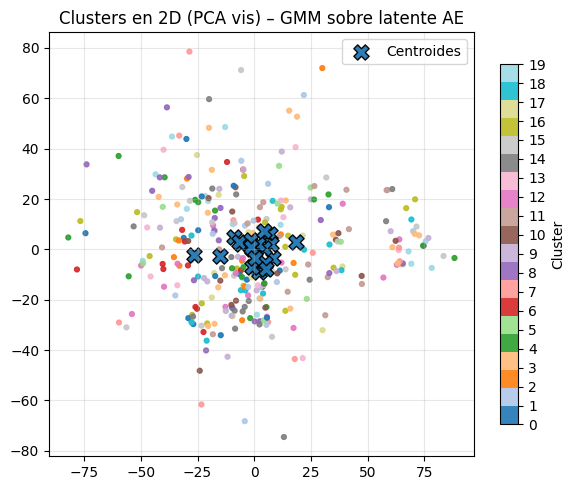

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PCA 2D solo para visualizar
pca2 = pre.pca_fit(Xtr_std)
Z2 = pre.pca_transform(Xtr_std, pca2, k=2)

def plot_clusters_2d_by_label(Z2, labels, title="Clusters en 2D"):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    K = uniq.size
    cmap = plt.get_cmap("tab20", K)  # mapa discreto con K colores

    # scatter coloreado por cluster
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    cbar = plt.colorbar(sc, ticks=uniq, shrink=0.85)
    cbar.set_label("Cluster")

    # centroides en el espacio de visualización (promedio por etiqueta)
    centroids = np.vstack([Z2[labels==k].mean(axis=0) for k in uniq])
    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")

    # anotá tamaño de cada cluster (opcional)
    sizes = {int(k): int((labels==k).sum()) for k in uniq}
    #for k, (cx, cy) in zip(uniq, centroids):
        #plt.text(cx, cy, f"{k}\n({sizes[int(k)]})", ha="center", va="bottom", fontsize=9, weight="bold")

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()

# usá las etiquetas correctas del GMM que elegiste:
plot_clusters_2d_by_label(Z2, labels_pca, "Clusters en 2D (PCA vis) – GMM sobre latente PCA")
plot_clusters_2d_by_label(Z2, labels_ae,  "Clusters en 2D (PCA vis) – GMM sobre latente AE")


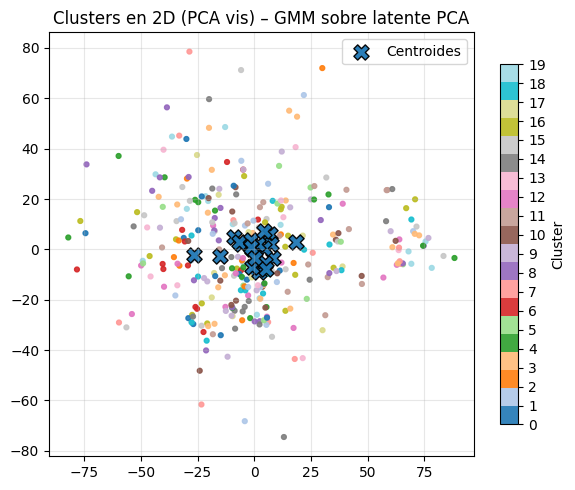

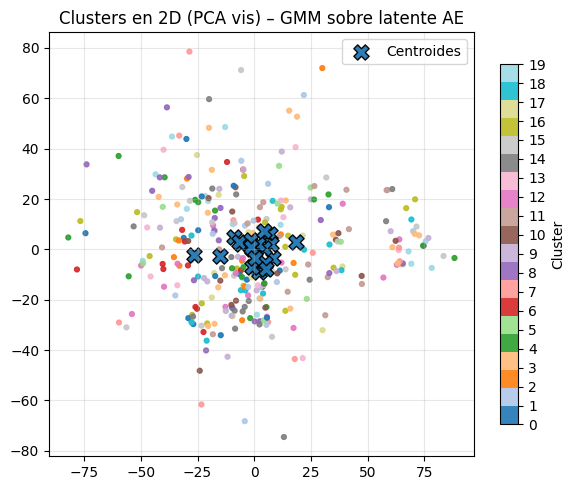

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PCA 2D solo para visualizar
pca2 = pre.pca_fit(Xtr_std)
Z2 = pre.pca_transform(Xtr_std, pca2, k=2)

def plot_clusters_2d_by_label(Z2, labels, title="Clusters en 2D"):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    K = uniq.size
    cmap = plt.get_cmap("tab20", K)  # mapa discreto con K colores

    # scatter coloreado por cluster
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    cbar = plt.colorbar(sc, ticks=uniq, shrink=0.85)
    cbar.set_label("Cluster")

    # centroides en el espacio de visualización (promedio por etiqueta)
    centroids = np.vstack([Z2[labels==k].mean(axis=0) for k in uniq])
    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")

    # anotá tamaño de cada cluster (opcional)
    sizes = {int(k): int((labels==k).sum()) for k in uniq}
    #for k, (cx, cy) in zip(uniq, centroids):
        #plt.text(cx, cy, f"{k}\n({sizes[int(k)]})", ha="center", va="bottom", fontsize=9, weight="bold")

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()

# usá las etiquetas correctas del GMM que elegiste:
plot_clusters_2d_by_label(Z2, labels_pca, "Clusters en 2D (PCA vis) – GMM sobre latente PCA")
plot_clusters_2d_by_label(Z2, labels_ae,  "Clusters en 2D (PCA vis) – GMM sobre latente AE")


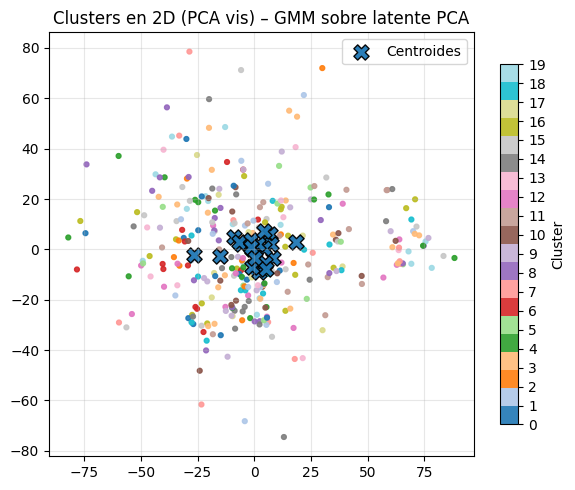

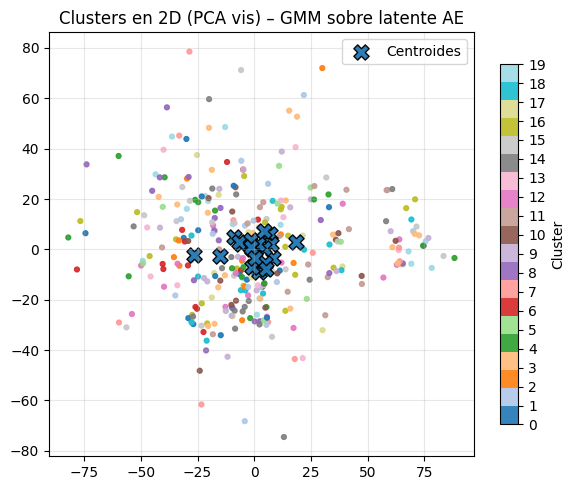

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PCA 2D solo para visualizar
pca2 = pre.pca_fit(Xtr_std)
Z2 = pre.pca_transform(Xtr_std, pca2, k=2)

def plot_clusters_2d_by_label(Z2, labels, title="Clusters en 2D"):
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    K = uniq.size
    cmap = plt.get_cmap("tab20", K)  # mapa discreto con K colores

    # scatter coloreado por cluster
    plt.figure(figsize=(6,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, s=12, cmap=cmap, vmin=uniq.min(), vmax=uniq.max(), alpha=0.9)
    cbar = plt.colorbar(sc, ticks=uniq, shrink=0.85)
    cbar.set_label("Cluster")

    # centroides en el espacio de visualización (promedio por etiqueta)
    centroids = np.vstack([Z2[labels==k].mean(axis=0) for k in uniq])
    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=120, edgecolor="k", linewidths=1.0, alpha=0.95, label="Centroides")

    # anotá tamaño de cada cluster (opcional)
    sizes = {int(k): int((labels==k).sum()) for k in uniq}
    #for k, (cx, cy) in zip(uniq, centroids):
        #plt.text(cx, cy, f"{k}\n({sizes[int(k)]})", ha="center", va="bottom", fontsize=9, weight="bold")

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()

# usá las etiquetas correctas del GMM que elegiste:
plot_clusters_2d_by_label(Z2, labels_pca, "Clusters en 2D (PCA vis) – GMM sobre latente PCA")
plot_clusters_2d_by_label(Z2, labels_ae,  "Clusters en 2D (PCA vis) – GMM sobre latente AE")


In [ ]:
import numpy as np, pandas as pd

def resumen_clusters(Z, labels, y_true=None):
    import numpy as np, pandas as pd
    uniq, counts = np.unique(labels, return_counts=True)
    sizes = pd.Series(counts, index=uniq, name="size").sort_values(ascending=False)
    out = {"K": len(uniq), "sizes": sizes}
    if y_true is not None:
        tab = pd.crosstab(pd.Series(labels, name="cluster"),
                          pd.Series(y_true, name="class"))
        purity = (tab.max(axis=1) / tab.sum(axis=1)).rename("purity")
        out["crosstab"] = tab
        out["purity_per_cluster"] = purity
        out["purity_weighted_mean"] = (purity * tab.sum(axis=1) / tab.sum().sum()).sum()
    return out


res_pca = resumen_clusters(Ztr_pca, labels_pca, ytr if ytr is not None else None)
res_ae  = resumen_clusters(z_tr,    labels_ae,  ytr if ytr is not None else None)

print("PCA | K:", res_pca["K"], "\nSizes:\n", res_pca["sizes"].to_string())
print("Purity weighted mean (PCA):", round(res_pca["purity_weighted_mean"],3))
print("\nAE  | K:", res_ae["K"], "\nSizes:\n", res_ae["sizes"].to_string())
print("Purity weighted mean (AE):", round(res_ae["purity_weighted_mean"],3))


PCA | K: 20 
Sizes:
 3     23
15    22
8     20
14    19
16    19
4     18
9     17
12    17
19    17
11    17
0     16
10    16
1     15
18    14
13    13
6     13
5     12
7     11
17    11
2     10
Purity weighted mean (PCA): 0.134

AE  | K: 20 
Sizes:
 3     23
15    22
8     20
14    19
16    19
4     18
9     17
12    17
19    17
11    17
0     16
10    16
1     15
18    14
13    13
6     13
5     12
7     11
17    11
2     10
Purity weighted mean (AE): 0.134


In [ ]:
# 1) ¿Cuántas clases hay en train?
C = np.unique(ytr).size
print("Nº de clases en ytr:", C)

# 2) Baseline de azar:
print("Baseline pureza ~ 1/C:", 1/C)

# 3) ¿Estamos usando la columna de etiqueta correcta?
# (si tu CSV tiene 'label' en otra columna, esto lo detecta)
import pandas as pd
df_head = pd.read_csv("data/caras.csv", nrows=3)
print("Columnas CSV:", list(df_head.columns)[:10])  # inspeccioná que 'label' exista y esté bien


Nº de clases en ytr: 40
Baseline pureza ~ 1/C: 0.025
Columnas CSV: ['pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9']


In [ ]:
import pandas as pd
def purity_weighted_mean(labels, y_true):
    tab = pd.crosstab(pd.Series(labels, name="cluster"), pd.Series(y_true, name="class"))
    purity = (tab.max(axis=1) / tab.sum(axis=1))
    return float((purity * tab.sum(axis=1) / tab.sum().sum()).sum()), tab, purity

pur_pca, tab_pca, pur_vec_pca = purity_weighted_mean(labels_pca, ytr)
pur_ae,  tab_ae,  pur_vec_ae  = purity_weighted_mean(labels_ae,  ytr)

print("Pureza ponderada (PCA):", round(pur_pca, 3))
print("Pureza ponderada (AE) :", round(pur_ae, 3))
display(tab_pca.head())  # mira algunas filas


Pureza ponderada (PCA): 0.134
Pureza ponderada (AE) : 0.134


class,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,2,1,1,0,0,0,0,...,1,0,0,0,1,1,0,1,0,0
1,0,0,1,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,2,0,0
2,0,0,0,1,1,0,0,0,0,1,...,0,2,0,0,0,0,0,0,0,0
3,0,0,2,2,1,0,0,0,0,0,...,0,2,0,0,0,1,0,1,2,1
4,0,1,1,0,0,1,1,1,0,1,...,0,0,1,1,0,0,1,1,0,0
